In [1]:
import os
from sys import stdout
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peakutils
%matplotlib inline 
from math import sqrt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.linear_model import ElasticNet,ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
    mse = []
    component = np.arange(1, n_comp)
    for i in component:
        pls = PLSRegression(n_components=i)
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
        mse.append(mean_squared_error(y, y_cv))
        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
        plt.show()
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
    
    return
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
"""   
    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$Brix')
        plt.ylabel('Measured $^{\circ}$Brix')
        plt.show()
    return
""" 

"   \n    # Fit a line to the CV vs response\n    z = np.polyfit(y, y_c, 1)\n    with plt.style.context(('ggplot')):\n        fig, ax = plt.subplots(figsize=(9, 5))\n        ax.scatter(y_c, y, c='red', edgecolors='k')\n        #Plot the best fit line\n        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)\n        #Plot the ideal 1:1 line\n        ax.plot(y, y, color='green', linewidth=1)\n        plt.title('$R^{2}$ (CV): '+str(score_cv))\n        plt.xlabel('Predicted $^{\\circ}$Brix')\n        plt.ylabel('Measured $^{\\circ}$Brix')\n        plt.show()\n    return\n"

In [3]:
def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))
    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]
        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)
            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()
    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
    Xc = X[:,sorted_ind]
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [4]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return (data_msc, ref)

In [259]:
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        data_snv[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    return data_snv

In [5]:
x_df = pd.read_csv('avg_base_norm.csv', sep = ',')
values = x_df.values
#wl=x_df.columns.values
#print(wl.shape)

#print(values)
#print(type(values))
print(values.shape)
print(values[1].shape)
print(len(values))
x_df

(24, 1446)
(1446,)
24


,252.071400,252.201700,252.331900,252.462200,252.592400,252.722600,252.852900,252.983100,253.113300,253.243600,...,428.718100,428.828600,428.939000,429.049500,429.159900,429.270300,429.380600,429.491000,429.601300,429.711600
0,-0.000051,-0.000137,-0.000348,0.000134,-0.000060,-0.000077,0.000103,0.000288,0.000048,-0.000200,...,0.000521,0.001721,0.004923,0.003764,0.001069,0.000188,-0.000245,-0.000420,-0.000480,-0.000328
1,-0.001183,-0.001046,-0.001689,-0.000682,-0.000926,-0.001222,-0.000757,-0.000432,-0.000893,-0.001300,...,0.000315,-0.000633,-0.000929,-0.000934,-0.000485,-0.000438,-0.001200,-0.001419,-0.001679,-0.001496
2,-0.000382,-0.000548,-0.001030,-0.000186,-0.000471,-0.000625,-0.000407,0.000065,-0.000358,-0.000748,...,0.000356,-0.000319,-0.000437,-0.000497,-0.000020,-0.000095,-0.000618,-0.000748,-0.000897,-0.000763
3,-0.000632,-0.000785,-0.001162,-0.000292,-0.000639,-0.000852,-0.000558,-0.000084,-0.000512,-0.000889,...,0.000334,-0.000420,-0.000335,-0.000562,-0.000090,-0.000270,-0.000825,-0.001128,-0.001327,-0.001101
4,0.000615,0.000247,0.000025,0.000840,0.000589,0.000853,0.001643,0.001616,0.000699,-0.000022,...,0.000197,-0.000316,-0.000706,-0.000500,-0.000089,-0.000213,-0.000574,-0.000726,-0.000858,-0.000666
5,0.000623,0.000112,-0.000077,0.000916,0.000636,0.000809,0.001711,0.001559,0.000529,-0.000098,...,0.000244,-0.000184,-0.000098,-0.000164,-0.000065,-0.000170,-0.000652,-0.000780,-0.000873,-0.000697
6,-0.000321,-0.000409,-0.000991,0.000060,-0.000408,-0.000826,-0.000322,0.000093,-0.000523,-0.001165,...,0.000609,-0.000264,-0.000513,-0.000529,0.000029,0.000076,-0.000625,-0.000945,-0.001089,-0.000953
7,-0.000210,-0.000352,-0.000602,0.000056,-0.000297,-0.000301,-0.000004,0.000193,-0.000140,-0.000479,...,0.000458,-0.000105,-0.000136,-0.000052,0.000116,0.000011,-0.000311,-0.000540,-0.000697,-0.000556
8,0.000343,0.000048,-0.000111,0.000531,0.000399,0.000530,0.001000,0.001059,0.000538,0.000049,...,0.000453,0.000015,-0.000034,-0.000083,0.000113,0.000099,-0.000159,-0.000174,-0.000329,-0.000161
9,0.000988,0.000493,0.000385,0.001313,0.001123,0.001451,0.002381,0.002267,0.001154,0.000555,...,0.000314,-0.000088,-0.000269,-0.000253,0.000022,0.000058,-0.000175,-0.000349,-0.000454,-0.000300


[252.0714 252.2017 252.3319 ... 429.491  429.6013 429.7116]


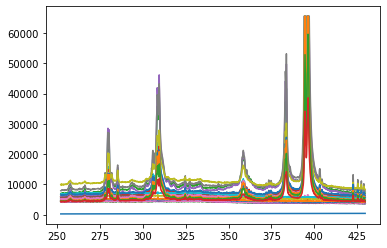

In [6]:
#This is just for visualizing the various plots of the samples

df = pd.read_csv('./ref_new/1.csv')
data=df.values
wl= data[0]
print(wl)

for i in range(len(values)):
    plt.plot(wl, data[i,:])
    #plt.show() #comment this one to have unique plot instead of multiple ones
#range(len(dfs))
#"""



In [7]:
df_y = pd.read_csv('concentration_1.csv', sep = ',')
print(type(df_y))
concentration=df_y.values
print(concentration.shape)
#print(concentration)

y_values=df_y.values
y_all=pd.DataFrame(y_values[:,1:-2])
#print(y_all)
df_y

<class 'pandas.core.frame.DataFrame'>
(24, 9)


,Reference Number,Si,Fe,Mg,Cu,Zn,Mn,Al,Total
0,1,0.185,0.228,2.940,0.0304,0.0620,0.280,96.0000,99.7254
1,2,0.360,0.600,1.100,0.0700,0.2000,0.830,96.5787,99.7387
2,3,9.140,1.010,0.200,0.4200,3.6000,0.410,84.7770,99.5570
3,4,8.565,0.000,0.293,0.8870,2.6360,0.330,86.5650,99.2760
4,5,9.500,0.000,0.391,0.0000,0.0580,0.016,90.0210,99.9860
5,6,7.220,0.140,0.360,0.0840,0.1200,0.053,91.8090,99.7860
6,7,7.460,0.530,0.036,0.1400,0.1500,0.100,91.4140,99.8300
7,8,12.900,0.120,0.520,0.1550,0.5200,0.286,84.7905,99.2915
8,9,8.750,0.460,1.710,0.0290,2.0000,0.056,85.3100,98.3150
9,10,0.260,0.420,1.260,0.0200,0.0040,1.160,96.8346,99.9586


In [8]:
y_val = concentration[:,3]
print(y_val)
print(y_val.shape)
y_df= pd.DataFrame(y_val)
#y_df

[2.94  1.1   0.2   0.293 0.391 0.36  0.036 0.52  1.71  1.26  0.41  0.88
 0.32  0.025 0.77  4.54  0.57  0.39  3.57  0.339 0.363 2.48  1.11  2.03 ]
(24,)


In [9]:
target = [251.59, 288.12, 390.60]
target

[251.59, 288.12, 390.6]

In [10]:
a = []
b = []
for t in target:
    for i in range(len(wl)):
        if abs(wl[i]-t) < 1.5:
            a.append(wl[i])
            b.append(i)
            
print("number of selected wavelengths: ",len(a), "\n")
print(a, "\n")
print(b)

number of selected wavelengths:  56 

[252.0714, 252.2017, 252.3319, 252.4622, 252.5924, 252.7226, 252.8529, 252.9831, 286.6869, 286.8158, 286.9447, 287.0735, 287.2024, 287.3313, 287.4601, 287.5889, 287.7178, 287.8466, 287.9754, 288.1042, 288.233, 288.3618, 288.4906, 288.6194, 288.7482, 288.8769, 289.0057, 289.1345, 289.2632, 289.3919, 289.5207, 389.203, 389.3212, 389.4394, 389.5576, 389.6757, 389.7939, 389.912, 390.0301, 390.1481, 390.2662, 390.3842, 390.5023, 390.6203, 390.7382, 390.8562, 390.9741, 391.0921, 391.21, 391.3278, 391.4457, 391.5635, 391.6814, 391.7992, 391.917, 392.0347] 

[0, 1, 2, 3, 4, 5, 6, 7, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115]


In [29]:
print(values.shape)
values[:, b].shape
x_selecta = pd.DataFrame(values[:, b])
x_selecta

(24, 1446)


,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,-0.000051,-0.000137,-0.000348,0.000134,-0.000060,-0.000077,0.000103,0.000288,-0.000112,-0.000165,...,0.007227,0.007327,0.007341,0.007692,0.007941,0.008409,0.008798,0.009385,0.010252,0.010720
1,-0.001183,-0.001046,-0.001689,-0.000682,-0.000926,-0.001222,-0.000757,-0.000432,-0.001589,-0.001217,...,0.004913,0.004809,0.005029,0.005381,0.005397,0.006014,0.006409,0.006595,0.007521,0.007988
2,-0.000382,-0.000548,-0.001030,-0.000186,-0.000471,-0.000625,-0.000407,0.000065,-0.001242,-0.001063,...,0.005611,0.005747,0.005737,0.006017,0.006289,0.006844,0.007219,0.007418,0.008370,0.008860
3,-0.000632,-0.000785,-0.001162,-0.000292,-0.000639,-0.000852,-0.000558,-0.000084,-0.001209,-0.001077,...,0.005954,0.005963,0.006061,0.006496,0.006746,0.007322,0.007612,0.007802,0.008897,0.009378
4,0.000615,0.000247,0.000025,0.000840,0.000589,0.000853,0.001643,0.001616,-0.001052,-0.000853,...,0.007588,0.007138,0.006655,0.006675,0.006816,0.007139,0.007304,0.007460,0.008203,0.008617
5,0.000623,0.000112,-0.000077,0.000916,0.000636,0.000809,0.001711,0.001559,-0.001166,-0.000986,...,0.007252,0.006801,0.006435,0.006619,0.006538,0.006974,0.007067,0.007287,0.008081,0.008409
6,-0.000321,-0.000409,-0.000991,0.000060,-0.000408,-0.000826,-0.000322,0.000093,-0.001324,-0.001059,...,0.005149,0.005162,0.004800,0.005468,0.005582,0.006197,0.006383,0.006366,0.007529,0.007818
7,-0.000210,-0.000352,-0.000602,0.000056,-0.000297,-0.000301,-0.000004,0.000193,-0.000066,0.000048,...,0.006258,0.006245,0.005997,0.006438,0.006420,0.006790,0.006929,0.006966,0.007848,0.008162
8,0.000343,0.000048,-0.000111,0.000531,0.000399,0.000530,0.001000,0.001059,-0.000974,-0.000937,...,0.006458,0.006347,0.006166,0.006577,0.006734,0.007114,0.007376,0.007740,0.008538,0.008981
9,0.000988,0.000493,0.000385,0.001313,0.001123,0.001451,0.002381,0.002267,-0.001265,-0.001069,...,0.007922,0.007301,0.006884,0.007085,0.007126,0.007400,0.007644,0.007914,0.008691,0.009126


In [30]:
X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

#print(X_test)

(19, 56) (19, 1)
(5, 56) (5, 1)


In [31]:
n_components= 20

# PCA

X_std = StandardScaler().fit_transform(x_selecta.values)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

principalComponents = pca.fit_transform(X_std)
print(principalComponents.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
#print(pca.singular_values_)

(24, 20)
[ 57.26  87.81  96.86  98.17  99.01  99.34  99.53  99.69  99.76  99.81
  99.84  99.87  99.9   99.92  99.94  99.96  99.97  99.98  99.99 100.  ]


In [32]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(principalComponents, y_df)
# Calibration
y_c = regr.predict(principalComponents)
# Cross-validation
y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_df, y_c)
score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_df, y_c)
mse_cv = mean_squared_error(y_df, y_cv)

print(score_c, score_cv)
print(mse_c, mse_cv)

0.8101459469906304 -7271.336416861637
3.829755305278809 146698.31132271708


In [33]:
n_components=18

x = X_train.values
x_t = X_test.values
print(x.shape)
print(x[1].shape)
print(len(x))


# This has to be used later for regression, PCA is done on X only
"""
y_df = pd.read_csv('labels_aligned+.csv', sep = ',')
concentration=y_df.values
#print(concentration)
multi_y = concentration[:,2:]
#print (multi_y)
print (multi_y.shape)
multi_y= np.array(multi_y, dtype=np.float)
y=np.around(multi_y, decimals=4)
#print(y)
"""

# PCA

X_std = StandardScaler().fit_transform(x)
X_std_test = StandardScaler().fit_transform(x_t)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

x_pc = pca.fit_transform(X_std)
x_test1 = pca.transform(X_std_test)
print(x_pc.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

(19, 56)
(56,)
19
(19, 18)
[61.75 90.19 96.96 98.27 99.14 99.39 99.57 99.74 99.81 99.86 99.89 99.92
 99.94 99.96 99.97 99.98 99.99 99.99]


In [34]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(x_pc, y_train)
# Calibration
y_c = regr.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_c)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_c)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2_pred: ", score_c)
print("MSE: ", mse_c)

R2_pred:  -1.6381598639648058
MSE:  51.858202919561634


In [35]:
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_selecta.values, y_df, 20)

100% completed
Optimised number of PLS components:  16
Wavelengths to be discarded  24
Optimised MSEP  8.667832146355162



(19, 32) (19, 1)
(5, 32) (5, 1)
50% completed
Suggested number of components:  1



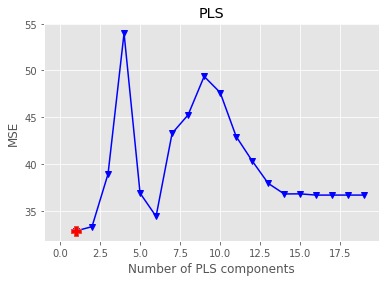

R2 calib: 0.052
R2 CV: -0.501
MSE calib: 20.746
MSE CV: 32.835


In [37]:
X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

optimise_pls_cv(X_train,y_train, 20, plot_components=True)

R2_pred: -0.7160073417048995
R2_cv: -0.6764037693486473 

[real, predictions]
[[ 7.22        2.71815733]
 [ 6.16        1.11877812]
 [ 0.26        0.85970057]
 [ 9.14       16.22425016]
 [ 0.16        4.76953591]]


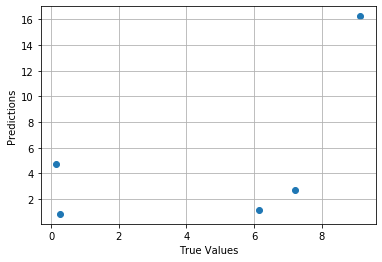

In [41]:
# Define PLS object
pls = PLSRegression(n_components=26)
# Fit
pls.fit(X_train, y_train)
# Cross-validation
y_pred = pls.predict(X_test)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred:", score_pred)
print("R2_cv:",score_cv, "\n")

b=np.append(y_test, y_pred, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

In [38]:
Xmsc = msc(x_df.values)
Xmsc[0]

array([[-0.00432779, -0.00445947, -0.00459477, ..., -0.0070824 ,
        -0.00697957, -0.00694981],
       [-0.00300622, -0.00289671, -0.00330585, ..., -0.01077987,
        -0.01069323, -0.01084606],
       [-0.00490734, -0.00516648, -0.00522813, ..., -0.00778191,
        -0.00777324, -0.00787054],
       ...,
       [-0.00333413, -0.00366814, -0.00372828, ..., -0.0062468 ,
        -0.00596367, -0.0061552 ],
       [-0.00552155, -0.00564901, -0.00586207, ..., -0.00698353,
        -0.0073193 , -0.00732596],
       [-0.00662448, -0.00681398, -0.00687648, ..., -0.00805989,
        -0.00812742, -0.00792078]])

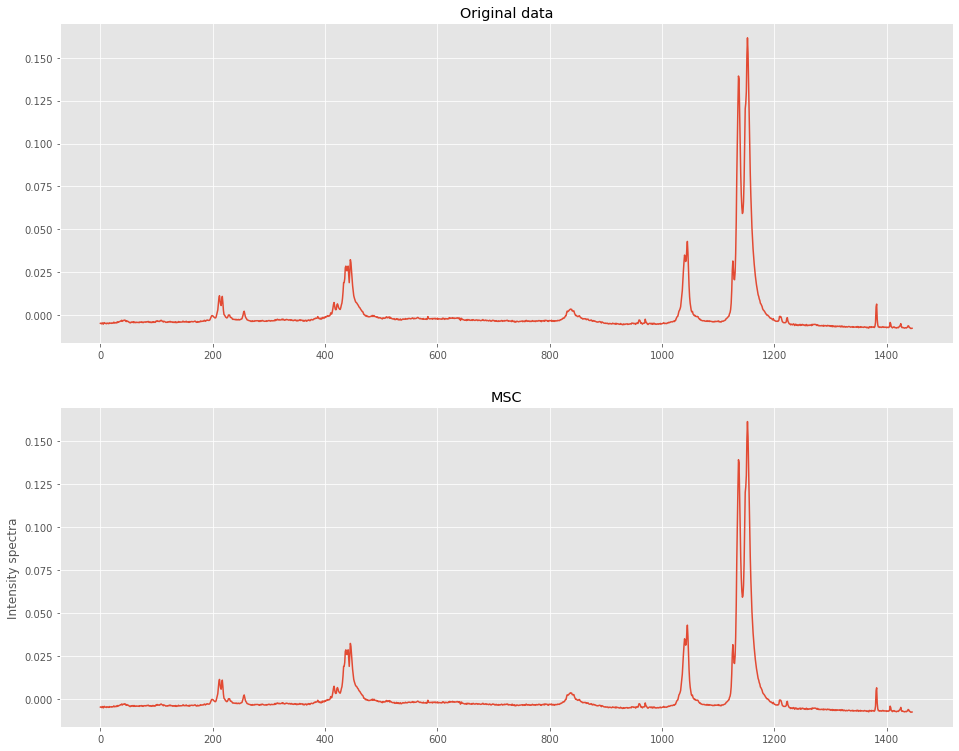

In [136]:
X = x_df.values[0,:].reshape(1,-1)
#wl
Xmsc = msc(X)[0] # Take the first element of the output tuple

%matplotlib inline
## Plot spectra
plt.figure(figsize=(16,20))
with plt.style.context(('ggplot')):
    ax1 = plt.subplot(311)
    plt.plot(X.T)
    #plt.plot(wl.T, X.T)
    plt.title('Original data')
    ax2 = plt.subplot(312)
    plt.plot(Xmsc.T)
    #plt.plot(wl.T, Xmsc.T)
    plt.ylabel('Intensity spectra')
    plt.title('MSC')
    plt.show()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(19, 1446) (19, 1)
(5, 1446) (5, 1)
        0
11  0.880
5   0.360
0   2.940
6   0.036
7   0.520


# Principal Components Analysis

In [11]:
n_components=20

x_df = pd.read_csv('avg_base_norm.csv', sep = ',')
x = x_df.values
print(x.shape)
print(x[1].shape)
print(len(x))


# This has to be used later for regression, PCA is done on X only
"""
y_df = pd.read_csv('labels_aligned+.csv', sep = ',')
concentration=y_df.values
#print(concentration)
multi_y = concentration[:,2:]
#print (multi_y)
print (multi_y.shape)
multi_y= np.array(multi_y, dtype=np.float)
y=np.around(multi_y, decimals=4)
#print(y)
"""

# PCA

X_std = StandardScaler().fit_transform(x)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

principalComponents = pca.fit_transform(X_std)
print(principalComponents.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
#print(pca.singular_values_)

(24, 1446)
(1446,)
24
(24, 20)
[33.36 57.43 68.68 77.5  84.83 88.22 90.68 93.08 94.61 95.94 96.79 97.44
 98.03 98.41 98.73 98.99 99.2  99.4  99.57 99.71]


In [12]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(principalComponents, y_df)
# Calibration
y_c = regr.predict(principalComponents)
# Cross-validation
y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_df, y_c)
score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_df, y_c)
mse_cv = mean_squared_error(y_df, y_cv)

In [13]:
print(score_c, score_cv)
print(mse_c, mse_cv)

0.982683032848459 -233.4568916900284
0.023644987854542082 320.13286783483335


In [16]:
n_components=15

x = X_train.values
x_t = X_test.values
print(x.shape)
print(x[1].shape)
print(len(x))


# This has to be used later for regression, PCA is done on X only
"""
y_df = pd.read_csv('labels_aligned+.csv', sep = ',')
concentration=y_df.values
#print(concentration)
multi_y = concentration[:,2:]
#print (multi_y)
print (multi_y.shape)
multi_y= np.array(multi_y, dtype=np.float)
y=np.around(multi_y, decimals=4)
#print(y)
"""

# PCA

X_std = StandardScaler().fit_transform(x)
X_std_test = StandardScaler().fit_transform(x_t)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

x_pc = pca.fit_transform(X_std)
x_test1 = pca.transform(X_std_test)
print(x_pc.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

(19, 1446)
(1446,)
19
(19, 15)
[35.85 60.9  72.68 81.66 88.26 91.81 94.29 95.75 96.84 97.6  98.16 98.58
 98.97 99.27 99.51]


In [17]:
x_test1

array([[  5.63856668,  23.08835309,  -9.73293309,  10.3798126 ,
         -5.34225827,  -8.76864809,   3.09673656,  -2.99491098,
          3.99776425,   2.4634476 ,  -9.51690062,  -3.65407071,
          5.63468961,   1.5497209 ,   0.74242609],
       [-20.30758424,  -0.42339392,  15.69945744,   0.8237185 ,
         10.75841938,  -3.22239527,  -9.10237453,   4.57836927,
         -3.8526803 ,   6.61426283,  -3.04824177,   1.83944735,
         -3.91503304,  -5.12549702,  -4.23552779],
       [ -3.51415514, -11.98794428,   6.6379223 , -15.41429824,
        -24.30840608,   1.86649393,   0.32574675,   5.49201362,
          3.33680451,  -1.20568148,   5.84879982,  -3.39758773,
         -3.44713625,   0.6285108 ,   3.13735447],
       [-11.88545294,  -1.56407651, -14.07358709,   1.48624025,
         17.99230099,   7.85269938,  -0.95785659,  -5.28296317,
          1.28637163,  -5.32225607,   2.97990681,   6.08570965,
          3.67371683,   0.88894942,   1.48869127],
       [ 30.06862563,  -9.11

In [18]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(x_pc, y_train)
# Calibration
y_c = regr.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_c)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_c)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2: ", score_c)
print("MSE: ", mse_c)

R2:  -0.5402952417594689
MSE:  1.6429888203291014


37% completed
Suggested number of components:  1



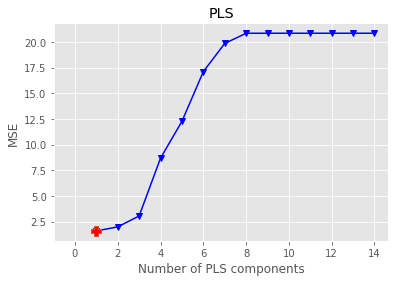

R2 calib: 0.935
R2 CV: -0.105
MSE calib: 0.094
MSE CV: 1.586


In [19]:
optimise_pls_cv(x_pc, y_train, 15, plot_components=True) 

In [22]:
pls = PLSRegression(n_components=7)
# Fit
pls.fit(x_pc, y_train)
# Calibration
y_c = pls.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_c)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_c)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2: ", score_c)
print("MSE: ", mse_c)

R2:  -0.5402952417594666
MSE:  1.642988820329099


#### This is the *mathematical* way to do it

(1508.8695652173917+0j)
[47.43 65.94 74.18 81.21 85.42 88.88 91.66 93.52 94.9  95.92 96.71 97.28
 97.78 98.2  98.59 98.86 99.09 99.3  99.46 99.62]


"# Make a list of (eigenvalue, eigenvector) tuples\neig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]\n\n# Sort the (eigenvalue, eigenvector) tuples from high to low\neig_pairs.sort(key=lambda x: x[0], reverse=True)\n\n# Visually confirm that the list is correctly sorted by decreasing eigenvalues\nprint('Eigenvalues in descending order:')\nfor i in eig_pairs[:20]: #only first 20 eigenvalues\n    print(i[0])\n"

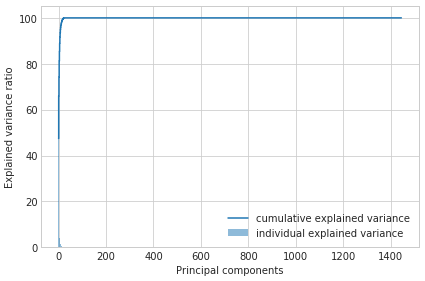

In [24]:
cov_mat = np.cov(X_std.T) #covariance matrix
#print('NumPy covariance matrix: \n%s' %np.cov(X_std.T))

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

#print('Eigenvectors \n%s' %eig_vecs)
#print('\nEigenvalues \n%s' %eig_vals)

tot = sum(eig_vals)
print(tot)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
#print(cum_var_exp.real)
print(np.round(cum_var_exp[:20].real, decimals=2)) # same as above but only first 10 elements

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(len(var_exp)), var_exp, alpha=0.5, align='center', label='individual explained variance')
    plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid', label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    
'''# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs[:20]: #only first 20 eigenvalues
    print(i[0])
'''

# Linear Regression
this is ordinary least square regression

In [23]:


# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

In [24]:
b=np.append(y_test, predictions, axis=1)

print("[real, predictions]")
print(b)

[real, predictions]
[[0.88       0.1241113 ]
 [0.36       1.71453431]
 [2.94       7.84232113]
 [0.036      1.56825637]
 [0.52       4.84333243]]


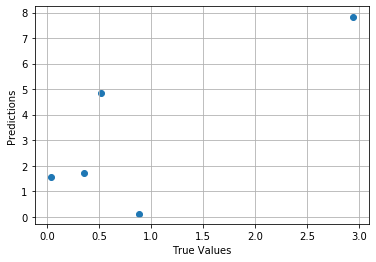

In [25]:
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

In [26]:
rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print("RMSE: ", rmse)
print("R^2: ", r2)

RMSE:  3.0814897786758393
R^2:  -7.902066383486357


# Partial Least Square Regression

## No preprocessing

In [27]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)
y_test

(19, 1446) (19, 1)
(5, 1446) (5, 1)


,0
11,0.880
8,1.710
3,0.293
21,2.480
4,0.391


100% completed
Suggested number of components:  3



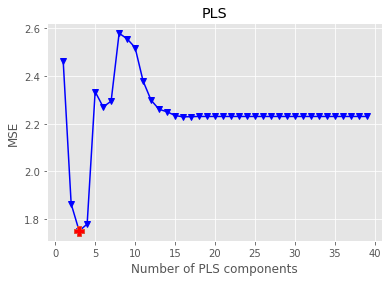

R2 calib: 0.656
R2 CV: -0.281
MSE calib: 0.470
MSE CV: 1.750


In [28]:
optimise_pls_cv(x_df, y_df, 40, plot_components=True)
#optimise_pls_cv(x_df, y_all, 40, plot_components=True)

In [31]:
# Define PLS object
pls = PLSRegression(n_components=3)
# Fit
pls.fit(x_df, y_df)
# Cross-validation
y_cv = cross_val_predict(pls, x_df, y_df, cv=10)
# Calculate scores
score = r2_score(y_df, y_cv)
mse = mean_squared_error(y_df, y_cv)

print("R^2_cv", score)
print("MSE: ", mse)

R^2_cv -0.2814971446543939
MSE:  1.749785869304901


100% completed
Suggested number of components:  3



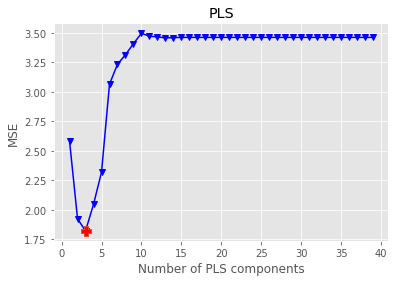

R2 calib: 0.652
R2 CV: -0.182
MSE calib: 0.537
MSE CV: 1.822


In [32]:
optimise_pls_cv(X_train,y_train, 40, plot_components=True)

R2_pred:  -1.6724187879961692
R2_cv:  -0.18208423865757006

TEST
 [real, predictions]
[[0.88       2.48758708]
 [1.71       1.86444549]
 [0.293      2.26133851]
 [2.48       0.82458332]
 [0.391      0.58963879]]

TRAIN
 [real, predictions]
[[ 0.036       0.32059472]
 [ 3.57        2.27952523]
 [ 0.32        0.38307389]
 [ 0.41        0.70752447]
 [ 0.025       0.33321394]
 [ 0.363      -0.79325288]
 [ 0.339      -0.0831704 ]
 [ 2.94        2.89804989]
 [ 0.52        0.94288612]
 [ 1.26        2.30254572]
 [ 0.36        0.6957977 ]
 [ 0.77        0.59020249]
 [ 1.1         2.18249441]
 [ 1.11        1.10833606]
 [ 4.54        2.62815733]
 [ 0.57        1.13894039]
 [ 0.39        0.3804927 ]
 [ 0.2         0.5540617 ]
 [ 2.03        2.28352652]]


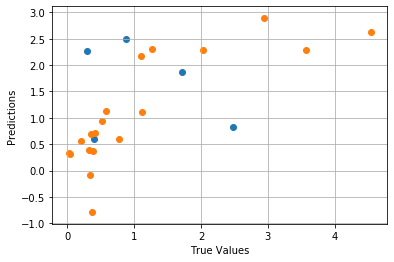

In [33]:
# Define PLS object
pls = PLSRegression(n_components=3)
# Fit
pls.fit(X_train, y_train)
# Cross-validation
y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

In [35]:
start_time = time.time()

opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_df.values, y_val, 15)

print("--- %s seconds ---" % (time.time() - start_time))

100% completed
Optimised number of PLS components:  8
Wavelengths to be discarded  1419
Optimised MSEP  0.3810360348246194

--- 327.237673997879 seconds ---


(24, 27)
sorted indexes:  [1020  693  719 ...   28 1396  122]
[380.7612 340.7848 344.0216 408.6626 385.8852 402.3183 429.0495 421.0338
 381.2393 316.6273]


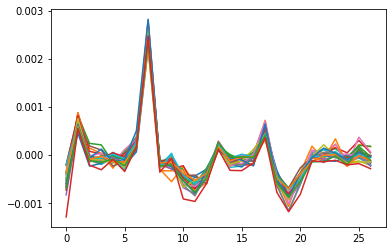

In [239]:
print(opt_Xc.shape)
print("sorted indexes: ", sorted_ind)
print(wl[sorted_ind[:10]].T)

plt.plot(opt_Xc.T)
plt.show()

In [261]:
X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state=3)
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(19, 27) (19, 1)
(5, 27) (5, 1)


,0
22,1.11
12,0.32
17,0.39
15,4.54
14,0.77


62% completed
Suggested number of components:  3



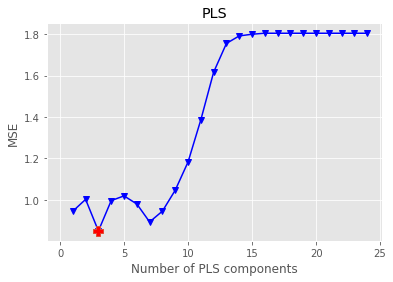

R2 calib: 0.835
R2 CV: 0.177
MSE calib: 0.170
MSE CV: 0.849


In [262]:
optimise_pls_cv(X_train,y_train, 25, plot_components=True)

R2_pred:  0.963985984111562
R2_cv:  -0.3431452799748351

TEST
 [real, predictions]
[[1.11       1.18326018]
 [0.32       0.07009963]
 [0.39       0.24296584]
 [4.54       4.91643929]
 [0.77       1.23892069]]



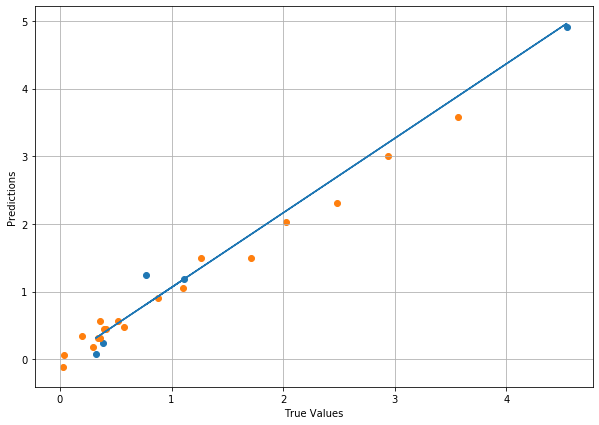

In [263]:
# Define PLS object
pls = PLSRegression(n_components=11)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Normalization

In [245]:
Xn_train = normalize(X_train, axis=1)
Xn_test = normalize(X_test, axis=1)
print(Xn_train.shape)
print(Xn_test.shape)

(19, 27)
(5, 27)


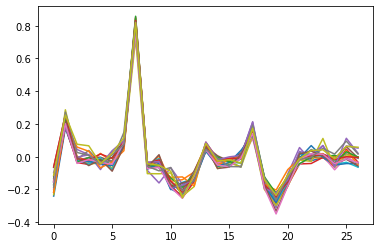

In [246]:
plt.plot(Xn_train.T)
plt.show()

62% completed
Suggested number of components:  9



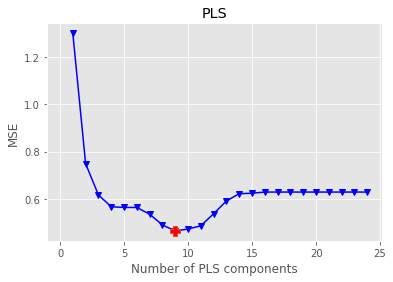

R2 calib: 0.995
R2 CV: 0.704
MSE calib: 0.009
MSE CV: 0.464


In [247]:
#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
optimise_pls_cv(Xn_train,y_train, 25, plot_components=True)

R2_pred:  0.5595310825838897
R2_cv:  0.6977363084995667

TEST
 [real, predictions]
[[ 0.391       0.56457518]
 [ 0.52        0.30950529]
 [ 0.339      -0.36216576]
 [ 2.03        1.49649073]
 [ 0.41        0.1342524 ]]



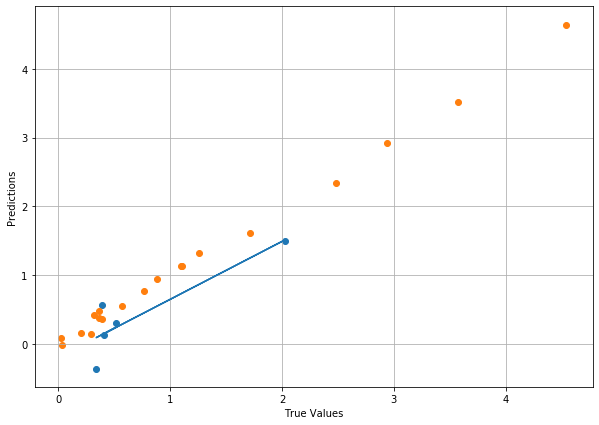

In [258]:
# Define PLS object
pls = PLSRegression(n_components=10)
# Fit
pls.fit(Xn_train, y_train)

y_pred = pls.predict(Xn_test)
y_pred1 = pls.predict(Xn_train)

# Cross-validation
y_cv = cross_val_predict(pls, Xn_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using SNV

(19, 27)
(5, 27)
62% completed
Suggested number of components:  9



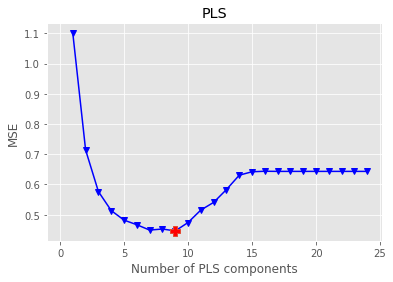

R2 calib: 0.996
R2 CV: 0.715
MSE calib: 0.007
MSE CV: 0.446


In [250]:
Xn_train = snv(X_train)
Xn_test = snv(X_test)
print(Xn_train.shape)
print(Xn_test.shape)

#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
optimise_pls_cv(Xn_train,y_train, 25, plot_components=True)

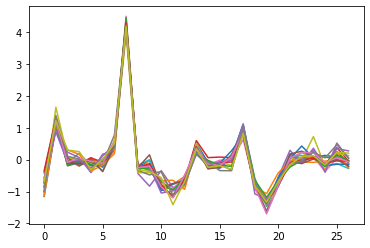

In [251]:
plt.plot(Xn_train.T)
plt.show()

R2_pred:  0.5595310825838897
R2_cv:  0.6977363084995667

TEST
 [real, predictions]
[[ 0.391       0.56457518]
 [ 0.52        0.30950529]
 [ 0.339      -0.36216576]
 [ 2.03        1.49649073]
 [ 0.41        0.1342524 ]]



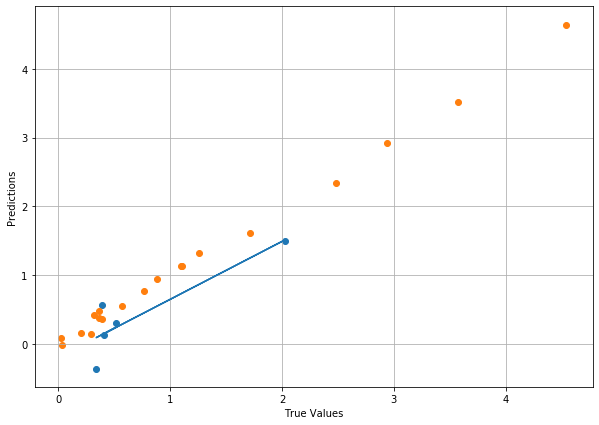

In [252]:
# Define PLS object
pls = PLSRegression(n_components=10)
# Fit
pls.fit(Xn_train, y_train)

y_pred = pls.predict(Xn_test)
y_pred1 = pls.predict(Xn_train)

# Cross-validation
y_cv = cross_val_predict(pls, Xn_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Savgol filter

In [160]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(19, 1446) (19, 1)
(5, 1446) (5, 1)


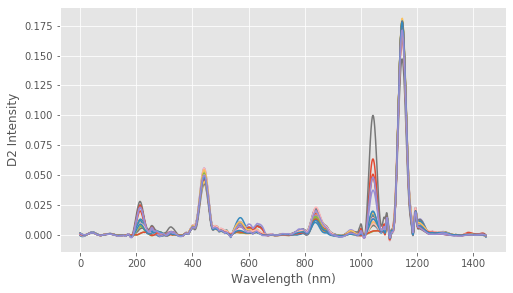

100% completed
Suggested number of components:  3



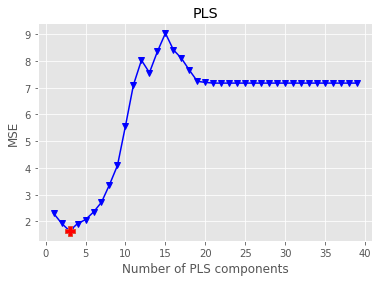

R2 calib: 0.517
R2 CV: -0.205
MSE calib: 0.660
MSE CV: 1.645


In [115]:
# Calculate second derivative
X2 = savgol_filter(x_df, 101, polyorder = 6,deriv=0) # Is this useful with LIBS spectra???
# Plot second derivative
plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(range(len(X2.T)), X2.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('D2 Intensity')
    plt.show()
    
    
X2_1 = msc(X2)[0]
    
optimise_pls_cv(X2_1, y_df, 40, plot_components=True)

100% completed
Suggested number of components:  4



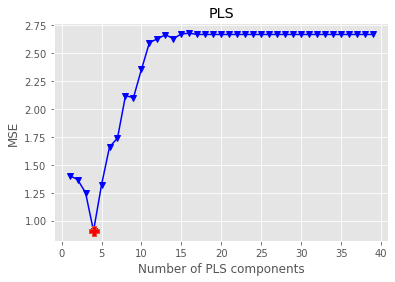

R2 calib: 0.796
R2 CV: 0.121
MSE calib: 0.210
MSE CV: 0.908


In [122]:
X2_train = savgol_filter(X_train, 37, polyorder = 4,deriv=0) 
X2_test = savgol_filter(X_test, 35, polyorder = 4,deriv=0) 




optimise_pls_cv(X2_train, y_train, 40, plot_components=True)

R2_pred:  -0.13492392041324552
R2_cv:  0.12073556685671827

[real, predictions]
[[1.11       1.38590257]
 [0.32       0.58834074]
 [0.39       1.43281912]
 [4.54       0.99576645]
 [0.77       0.12480451]]


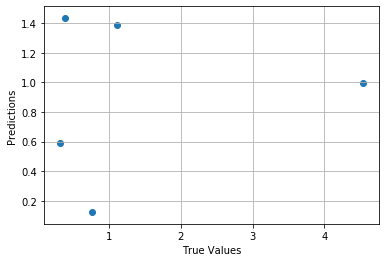

In [123]:
# Define PLS object
pls = PLSRegression(n_components=4)
# Fit
pls.fit(X2_train, y_train)

y_pred = pls.predict(X2_test)

# Cross-validation
y_cv = cross_val_predict(pls, X2_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Elastic Net

In [184]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

In [185]:
for a in alphas:
    model = ElasticNet(alpha=a).fit(X_train,y_train)   
    score = model.score(X_train, y_train)
    pred_y = model.predict(X_test)
    mse = mean_squared_error(y_test, pred_y)   
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))

Alpha:0.0001, R2:0.10, MSE:29.75, RMSE:5.45
Alpha:0.0010, R2:0.02, MSE:29.19, RMSE:5.40
Alpha:0.0100, R2:0.00, MSE:28.83, RMSE:5.37
Alpha:0.1000, R2:0.00, MSE:28.83, RMSE:5.37
Alpha:0.3000, R2:0.00, MSE:28.83, RMSE:5.37
Alpha:0.5000, R2:0.00, MSE:28.83, RMSE:5.37
Alpha:0.7000, R2:0.00, MSE:28.83, RMSE:5.37
Alpha:1.0000, R2:0.00, MSE:28.83, RMSE:5.37


In [186]:
model = ElasticNet(alpha=0.01).fit(X_train,y_train)   
score = model.score(X_train, y_train)
print("Train score: ", score)
pred_y = model.predict(X_test)


rmse = sqrt(mean_squared_error(y_test, pred_y))
r2 = r2_score(y_test, pred_y)
print("RMSE: ", rmse)
print("R^2: ", r2)

Train score:  1.2781745333589889e-05
RMSE:  5.36898101492605
R^2:  -0.7603728250353385


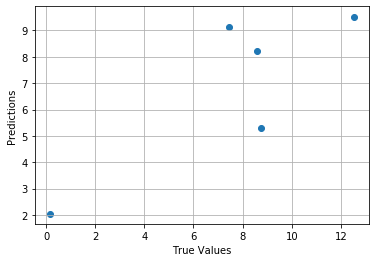

In [187]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Random Forest

In [84]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.15)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(20, 1446) (20, 1)
(4, 1446) (4, 1)


In [146]:
y_test=np.ravel(y_test)
print(y_test.shape)
y_train=np.ravel(y_train)
print(y_train.shape)

(5,)
(19,)


In [180]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 500, max_depth=30, random_state = 42)
# Train the model on training data
#rf.fit(X_train, y_train);

rf.fit(Xn_train, y_train);

In [181]:
# Use the forest's predict method on the test data

#predictions = rf.predict(X_test)
predictions = rf.predict(X_test)

# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 4.21


In [182]:
rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print("RMSE: ", rmse)
print("R^2: ", r2)

RMSE:  3.9912770579101613
R^2:  0.027152716203246885


In [150]:
y_test= y_test.reshape((len(y_test), 1))
print(y_test.shape)
print(type(y_test))
predictions=predictions.reshape((len(y_test), 1))
print(predictions.shape)
print(type(y_test))
#print((y_test, predictions))

(5, 1)
<class 'numpy.ndarray'>
(5, 1)
<class 'numpy.ndarray'>


In [151]:
b=np.append(y_test, predictions, axis=1)

print("[real, predictions]")
print(b)

[real, predictions]
[[ 0.16      2.315648]
 [ 7.46      5.096398]
 [ 8.75      3.14387 ]
 [ 8.565     5.224808]
 [12.53      7.015142]]


Text(0, 0.5, 'Predictions')

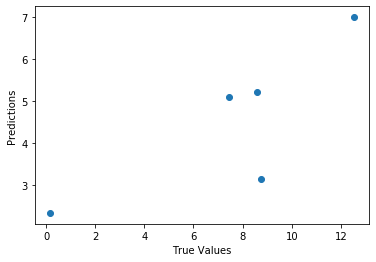

In [152]:
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [55]:
#I don't remember what's this

#X_train = normalize(X_train, axis=1)
#X_test = normalize(X_test, axis=1)

In [41]:
c

NameError: name 'c' is not defined

# MultiOutput Random Forest

In [132]:
multi_y = concentration[:,1:-2]
print (multi_y.shape)
print (type(multi_y))
df_y= pd.DataFrame(multi_y)
print (type(df_y))

(24, 6)
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [153]:
X_train, X_test, y_train, y_test = train_test_split(x_df, df_y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(19, 1130) (19, 6)
(5, 1130) (5, 6)


In [134]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=650,
                                                          max_depth=max_depth,
                                                          random_state=0))
regr_multirf.fit(X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=30,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=650,
                                                

In [135]:
y_multirf = regr_multirf.predict(X_test)

In [136]:
print(y_test.shape)
print(y_multirf.shape)

(5, 6)
(5, 6)


In [137]:
rmse = sqrt(mean_squared_error(y_test, y_multirf))
r2 = r2_score(y_test, y_multirf)

print("R^2: ", r2)
print("RMSE: ", rmse)

R^2:  -1.2798201186343863
RMSE:  1.5231794557929577


In [138]:
b=np.append(np.around(y_test,3), np.around(y_multirf,3), axis=1)

print("[real, predictions]")
print(b)

[real, predictions]
[[6.160e+00 0.000e+00 3.630e-01 0.000e+00 6.000e-03 2.060e-01 8.711e+00
  2.880e-01 4.460e-01 2.870e-01 7.790e-01 1.910e-01]
 [6.120e+00 0.000e+00 3.200e-01 0.000e+00 5.000e-03 1.600e-02 8.009e+00
  2.150e-01 4.630e-01 8.500e-02 1.110e-01 1.440e-01]
 [1.253e+01 3.100e-01 2.500e-02 5.000e-02 5.600e-02 3.300e-02 7.822e+00
  2.570e-01 2.970e-01 1.650e-01 1.750e-01 2.170e-01]
 [1.800e-01 5.000e-01 1.110e+00 5.200e-02 1.500e-01 1.260e+00 4.830e-01
  3.630e-01 1.233e+00 2.260e-01 1.360e-01 9.710e-01]
 [1.290e+01 1.200e-01 5.200e-01 1.550e-01 5.200e-01 2.860e-01 6.898e+00
  3.360e-01 7.140e-01 1.420e-01 5.610e-01 2.290e-01]]


Text(0, 0.5, 'Predictions')

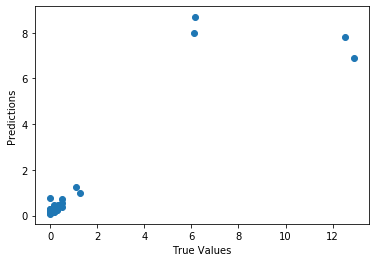

In [139]:
plt.scatter(y_test, y_multirf)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [141]:
y_pred=np.around(y_multirf,2)
y_pred[:,0]

array([8.71, 8.01, 7.82, 0.48, 6.9 ])

In [142]:
y_test[0].values

array([ 6.16,  6.12, 12.53,  0.18, 12.9 ])

In [143]:
print("real: ", y_test[0].values)
print("pred: ", y_pred[:,0])

real:  [ 6.16  6.12 12.53  0.18 12.9 ]
pred:  [8.71 8.01 7.82 0.48 6.9 ]


# PLS-2

100% completed
Suggested number of components:  33



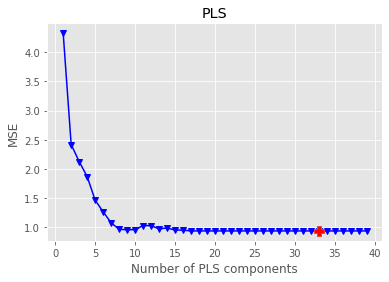

R2 calib: 1.000
R2 CV: 0.018
MSE calib: 0.000
MSE CV: 0.939


In [154]:
optimise_pls_cv(X_train, y_train, 40, plot_components=True)

In [155]:
# Define PLS object
pls = PLSRegression(n_components= 26)
# Fit
pls.fit(X_train, y_train)
# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)
# Calculate scores
score = r2_score(y_train, y_cv)
mse = mean_squared_error(y_train, y_cv)

print("R^2: ", score)
print("MSE: ", mse)

R^2:  0.018347253779067135
MSE:  0.9391318844120397


In [150]:
y_pred = pls.predict(X_test)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print(score_pred) #NAMMERDA
print(score_cv)

-4.070272705754876
0.36555579763038115


In [151]:
pd.DataFrame(np.round(y_pred, decimals=2))

,0,1,2,3,4,5
0,7.84,0.22,0.54,0.19,0.57,0.27
1,8.62,0.12,0.35,0.06,-0.12,-0.06
2,10.50,0.13,-0.61,0.45,0.15,-0.03
3,-0.28,0.42,1.56,-0.11,-0.34,0.95
4,9.93,0.09,0.29,-0.26,0.65,0.14


In [152]:
np.round(y_test, decimals=2)

,0,1,2,3,4,5
20,6.16,0.00,0.36,0.00,0.01,0.21
12,6.12,0.00,0.32,0.00,0.01,0.02
13,12.53,0.31,0.02,0.05,0.06,0.03
22,0.18,0.50,1.11,0.05,0.15,1.26
7,12.90,0.12,0.52,0.16,0.52,0.29
